***
# **Imports and create spark session**
***

# Imports

In [482]:
# *********** Reqular Imports************************
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import plotly.express as px


# ***********Pyspark Imports************************
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count, datediff, regexp_replace
from pyspark.sql.types import *

# Preprosesing Imports
from geopy.distance import geodesic
from pandas.core.arrays.datetimes import Day




# ***********Pyspark Machine Learning Imports************************
# Models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression

# Feature Selction and Preprocessing
from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

#Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.evaluation import RegressionEvaluator



# Some ouput options in notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

import plotly.io as pio
pio.renderers.default = "notebook_connected"

# Create Spark session

In [157]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# Loding the Data

In [158]:
# Loding the data
# read.csv is very similar to the Pandas version
df = spark.read.csv('FraudDataset.csv',
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

df.printSchema()

root
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [ ]:
df.select(
    [(
        count(when(isnan(c)|col(c).isNull(), c)) if t not in ("date", "timestamp") else count(when(col(c).isNull(), c))
        ).alias(c) for c, t in df.dtypes]).show()

+---------------------+------+--------+--------+------+------+------+----+-----+---+--------+---------+--------+---+---+--------------+---------------+--------+----+-----+---+----+------+------+---+-----------+---------+
|trans_date_trans_time|cc_num|merchant|category|amount|gender|street|city|state|zip|latitude|longitude|city_pop|job|dob|merch_latitude|merch_longitude|is_fraud|year|month|day|hour|minute|second|age|distance/km|card_type|
+---------------------+------+--------+--------+------+------+------+----+-----+---+--------+---------+--------+---+---+--------------+---------------+--------+----+-----+---+----+------+------+---+-----------+---------+
|                    0|     0|       0|       0|     0|     0|     0|   0|    0|  0|       0|        0|       0|  0|  0|             0|              0|       0|   0|    0|  0|   0|     0|     0|  0|          0|        0|
+---------------------+------+--------+--------+------+------+------+----+-----+---+--------+---------+--------+---+

**There is no null values**

***
# **Data Preprocessing**
***

In [159]:
# show the first 5 rows
df.show(5)

+---------------------+---------------+--------------------+-------------+------+-----+------+------+--------------------+-------------+-----+-----+-------+--------+--------+--------------------+----------+--------------------+----------+---------+------------------+--------+
|trans_date_trans_time|         cc_num|            merchant|     category|   amt|first|  last|gender|              street|         city|state|  zip|    lat|    long|city_pop|                 job|       dob|           trans_num| unix_time|merch_lat|        merch_long|is_fraud|
+---------------------+---------------+--------------------+-------------+------+-----+------+------+--------------------+-------------+-----+-----+-------+--------+--------+--------------------+----------+--------------------+----------+---------+------------------+--------+
|  2019-01-02 01:06:37|  4613314721966|fraud_Rutherford-...|  grocery_pos|281.06|Jason|Murphy|     M|542 Steve Curve S...|Collettsville|   NC|28611|35.9946|-81.7266|    

In [160]:
# we will start the preproccessing by renaming the columns to make it more representative
# we also delete unwanted columns which are first, last,unix_time,trans_num
df=df.withColumnRenamed("lat","latitude")\
.withColumnRenamed("long","longitude")\
.withColumnRenamed("amt","amount")\
.withColumnRenamed("merch_lat","merch_latitude")\
.withColumnRenamed("merch_long","merch_longitude").drop("first","last","trans_num")
# .withColumnRenamed("merch_long","merch_longitude").drop("first","last","unix_time","trans_num")

In [161]:
# print the sechema of the data
df.printSchema()

root
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_latitude: double (nullable = true)
 |-- merch_longitude: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [162]:
# show the fist 5 rows
df.show(5)

+---------------------+---------------+--------------------+-------------+------+------+--------------------+-------------+-----+-----+--------+---------+--------+--------------------+----------+----------+--------------+------------------+--------+
|trans_date_trans_time|         cc_num|            merchant|     category|amount|gender|              street|         city|state|  zip|latitude|longitude|city_pop|                 job|       dob| unix_time|merch_latitude|   merch_longitude|is_fraud|
+---------------------+---------------+--------------------+-------------+------+------+--------------------+-------------+-----+-----+--------+---------+--------+--------------------+----------+----------+--------------+------------------+--------+
|  2019-01-02 01:06:37|  4613314721966|fraud_Rutherford-...|  grocery_pos|281.06|     M|542 Steve Curve S...|Collettsville|   NC|28611| 35.9946| -81.7266|     885|      Soil scientist|1988-09-15|1325466397|     36.430124|-81.17948299999999|       1|


In [163]:
# We use the regexp_replace function to replace all the fraud_ in merchant coulmns 
df=df.withColumn("merchant",regexp_replace(df["merchant"],"fraud_",""))

In [164]:
# show the fist 20 rows
df.show()

+---------------------+----------------+--------------------+-------------+-------+------+--------------------+-------------+-----+-----+--------+---------+--------+--------------------+----------+----------+------------------+------------------+--------+
|trans_date_trans_time|          cc_num|            merchant|     category| amount|gender|              street|         city|state|  zip|latitude|longitude|city_pop|                 job|       dob| unix_time|    merch_latitude|   merch_longitude|is_fraud|
+---------------------+----------------+--------------------+-------------+-------+------+--------------------+-------------+-----+-----+--------+---------+--------+--------------------+----------+----------+------------------+------------------+--------+
|  2019-01-02 01:06:37|   4613314721966|    Rutherford-Mertz|  grocery_pos| 281.06|     M|542 Steve Curve S...|Collettsville|   NC|28611| 35.9946| -81.7266|     885|      Soil scientist|1988-09-15|1325466397|         36.430124|-81.1

In [165]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

# we will extract mulitple columns from trans_date_trans_time column 
df = df.withColumn("trans_date_trans_time", to_timestamp("trans_date_trans_time", 'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn('year', year(df.trans_date_trans_time))
df = df.withColumn('month', date_format(df.trans_date_trans_time,"LLLL")) # we convert the month from number of the month to name of the month
df = df.withColumn('day', date_format(df.trans_date_trans_time,"EEEE")) # we convert the month from number of the day to name of the day 
df = df.withColumn('hour', hour(df.trans_date_trans_time))
# df = df.withColumn('minute', minute(df.trans_date_trans_time))
# df = df.withColumn('second', second(df.trans_date_trans_time))

df.show(5, False)

+---------------------+---------------+--------------------------+-------------+------+------+-------------------------+-------------+-----+-----+--------+---------+--------+------------------------+----------+----------+--------------+------------------+--------+----+-----+---------+----+
|trans_date_trans_time|cc_num         |merchant                  |category     |amount|gender|street                   |city         |state|zip  |latitude|longitude|city_pop|job                     |dob       |unix_time |merch_latitude|merch_longitude   |is_fraud|year|month|day      |hour|
+---------------------+---------------+--------------------------+-------------+------+------+-------------------------+-------------+-----+-----+--------+---------+--------+------------------------+----------+----------+--------------+------------------+--------+----+-----+---------+----+
|2019-01-02 01:06:37  |4613314721966  |Rutherford-Mertz          |grocery_pos  |281.06|M     |542 Steve Curve Suite 011|Collett

In [166]:
# here we calculate the age of the person by subtract trans_date_trans_time from dob
# BY using the ceil and the datediff functins 
df=df.withColumn("age", F.ceil(F.datediff(col("trans_date_trans_time"),F.col("dob"))/365))

In [167]:
df.show()

+---------------------+----------------+--------------------+-------------+-------+------+--------------------+-------------+-----+-----+--------+---------+--------+--------------------+----------+----------+------------------+------------------+--------+----+-----+---------+----+---+
|trans_date_trans_time|          cc_num|            merchant|     category| amount|gender|              street|         city|state|  zip|latitude|longitude|city_pop|                 job|       dob| unix_time|    merch_latitude|   merch_longitude|is_fraud|year|month|      day|hour|age|
+---------------------+----------------+--------------------+-------------+-------+------+--------------------+-------------+-----+-----+--------+---------+--------+--------------------+----------+----------+------------------+------------------+--------+----+-----+---------+----+---+
|  2019-01-02 01:06:37|   4613314721966|    Rutherford-Mertz|  grocery_pos| 281.06|     M|542 Steve Curve S...|Collettsville|   NC|28611| 35.9

In [ ]:
df.select

In [168]:
df.printSchema()

root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_latitude: double (nullable = true)
 |-- merch_longitude: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- age: long (nullable = true)



In [169]:
# Here we creat a new column that calculate the distanse between the latitude and longitude

@F.udf(returnType=FloatType())
def geodesic_udf(latitude, longitude):
    return geodesic(latitude, longitude).km


df = df.withColumn('distance/km', geodesic_udf(F.array("latitude", "longitude"), F.array("merch_latitude", "merch_longitude")))

df.show()

+---------------------+----------------+--------------------+-------------+-------+------+--------------------+-------------+-----+-----+--------+---------+--------+--------------------+----------+----------+------------------+------------------+--------+----+-----+---------+----+---+-----------+
|trans_date_trans_time|          cc_num|            merchant|     category| amount|gender|              street|         city|state|  zip|latitude|longitude|city_pop|                 job|       dob| unix_time|    merch_latitude|   merch_longitude|is_fraud|year|month|      day|hour|age|distance/km|
+---------------------+----------------+--------------------+-------------+-------+------+--------------------+-------------+-----+-----+--------+---------+--------+--------------------+----------+----------+------------------+------------------+--------+----+-----+---------+----+---+-----------+
|  2019-01-02 01:06:37|   4613314721966|    Rutherford-Mertz|  grocery_pos| 281.06|     M|542 Steve Curve 

In [ ]:
# Here we created new column and we call it the card_type. 
# This new column generated from the cc_number 
@F.udf(returnType=StringType())
def card_type(cc_num):
    cc_num = str(cc_num)
    if cc_num[:1]=='4':
        return 'VISA'
    elif cc_num[:2]=='34':
        return 'American Express'
    elif cc_num[:2]=='37':
              return 'American Express'
    elif cc_num[:1]=='1':
        return 'Airline' 
    elif cc_num[:4]=='6011':
          return 'Discover '
    elif cc_num[:6]=='622126':
          return 'Discover'     
    elif cc_num[:1]=='2':
              return 'Mastercard'
    elif cc_num[:1]=='5':
              return 'Mastercard'          
    elif cc_num[:2]=='51':
              return 'Mastercard'
    elif cc_num[:2]=='52':
              return 'Mastercard'
    elif cc_num[:2]=='53':
              return 'Mastercard'
    elif cc_num[:2]=='54':
              return 'Mastercard'
    elif cc_num[:2]=='55':
              return 'Mastercard'         
    elif cc_num[:2]=='36':
              return 'DINERS'
    elif cc_num[:3]=='300 ':
              return 'DINERS' 
    elif cc_num[:3]=='301 ':
              return 'DINERS'
    elif cc_num[:3]=='302 ':
              return 'DINERS'
    elif cc_num[:3]=='303 ':
              return 'DINERS'
    elif cc_num[:3]=='304 ':
              return 'DINERS'
    elif cc_num[:3]=='305':
              return 'DINERS'
    elif cc_num[:3]=='359':
              return 'DINERS'                 
    else:
                return 'other'

df = df.withColumn('card_type', card_type(col("cc_num")))

In [25]:
df.write.options(delimiter=",", header=True).csv("Fraud_AfterPreprocessing.csv")

Py4JJavaError: An error occurred while calling o165.csv.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:209)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1$$Lambda$3149/882961937.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$2186/2111315646.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$2179/1181972775.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$Lambda$1865/86569746.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:851)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:343)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:344)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:901)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1046)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1055)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 22 more


In [26]:
df.toPandas().to_csv('Fraud_AfterPreprocessing.csv', index=False)

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 55826)
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Users\user\anaconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\Users\user\anaconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\user\anaconda3\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "c:\Users\user\anaconda3\lib\site-packages\pyspark\accumulators.py", line 281, in handle
    poll(accum_updates)
  File "c:\Users\user\anaconda3\lib\site-packages\pyspark\accumulators.py", line 253, in poll
    if func():
  File "c:\Users\user\anaconda3\lib\site-packages\pyspark\accumulators.py", line 257, in accum_updates
    num_u

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

***
# **EDA**
***

In [492]:
# p_df = pd.read_csv('FraudDataset.csv')
p_df = pd.read_csv('Fraud_AfterProcess.csv')

In [486]:
num_cols = [c for c, t in df.dtypes if not t.startswith(('timestamp','string'))]
df.select(num_cols).describe().show()

+-------+--------------------+-----------------+------------------+-----------------+------------------+-----------------+-------------------+-----------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+
|summary|              cc_num|           amount|               zip|         latitude|         longitude|         city_pop|          unix_time|   merch_latitude|   merch_longitude|            is_fraud|               year|             hour|               age|       distance/km|      merchant_idx|     category_idx|         gender_idx|        street_idx|          city_idx|         state_idx|           job_idx|
+-------+--------------------+-----------------+------------------+-----------------+------------------+-----------------+-------------------+-----------------+------------------+-

In [490]:
p_df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,5.632250e+05,563225.000000,563225.000000,563225.000000,563225.000000,5.632250e+05,5.632250e+05,563225.000000,563225.000000,563225.000000
mean,4.176057e+17,75.548833,48831.914398,38.544857,-90.227123,8.834256e+04,1.380249e+09,38.544278,-90.227175,0.017135
std,1.309403e+18,170.529091,26860.925816,5.062845,13.729378,3.007564e+05,6.553585e+06,5.097493,13.740796,0.129775
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325466e+09,19.027422,-166.671575,0.000000
25%,1.800429e+14,9.730000,26237.000000,34.690200,-96.798000,7.410000e+02,1.375827e+09,34.760443,-96.901767,0.000000
50%,3.521417e+15,47.840000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380581e+09,39.377368,-87.440158,0.000000
75%,4.635331e+15,84.440000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385842e+09,41.954514,-80.260118,0.000000
max,4.992346e+18,22768.110000,99921.000000,66.693300,-67.950300,2.906700e+06,1.388534e+09,67.510267,-66.952026,1.000000


**As we see above on the numircal columns statics every thing is ok an logical, maybe the cities that has less than 100 population is good to exploration.**

In [491]:
p_df.describe(exclude='number')

,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
count,563225,563225,563225,563225,563225,563225,563225,563225,563225,563225,563225,563225
unique,552261,693,14,355,486,2,999,906,51,497,984,563225
top,2020-12-13 17:53:47,fraud_Kilback LLC,gas_transport,Christopher,Smith,F,6983 Carrillo Isle,Birmingham,TX,Film/video editor,1977-03-23,e8a81877ae9a0a7f883e15cb39dc4022
freq,4,1906,56988,11606,12286,308621,1476,2434,40872,4163,2424,1


**As you see above the trans_date_trans_time column has datetime that has duplicate 4 times and that means 4 transiciton with same time in differnat merchants. Also, as you see there is only 693 merchant over the 906 cites and 51 states on 563225 rows. the data has 14 category of merchants and the gas trasport category has the most transiction with 56988 transactions. In the first and last columns only we get the smith last name it's common with 12000 record**

#### Distance Describe

In [31]:
df.select(col('distance/km')).where(col('is_fraud')==1).describe().show()

+-------+------------------+
|summary|       distance/km|
+-------+------------------+
|  count|              9651|
|   mean| 76.25494738056702|
| stddev|28.842378322813747|
|    min|        0.73782635|
|    max|          144.3559|
+-------+------------------+



In [32]:
df.select(col('distance/km')).where(col('is_fraud')==0).describe().show()

+-------+-----------------+
|summary|      distance/km|
+-------+-----------------+
|  count|           553574|
|   mean|76.10230942238063|
| stddev|29.09227144915324|
|    min|       0.12418035|
|    max|        150.67374|
+-------+-----------------+



#### Credit Card Number Describe

In [376]:
df.groupBy(F.col('cc_num')).count().orderBy(F.col('count').desc()).show()

+-------------------+-----+
|             cc_num|count|
+-------------------+-----+
|   4586810168620942| 1476|
|   6538441737335434| 1474|
|      4745996322265| 1472|
|4587657402165341696| 1463|
|   2242542703101233| 1443|
|     30273037698427| 1434|
|    372520049757633| 1409|
|   4364010865167176| 1390|
|     30270432095985| 1386|
|    344709867813900| 1372|
|   4642255475285942| 1358|
|    180094419304907| 1356|
|   3583635130604947| 1354|
|   4836998673805450| 1354|
|   3521417320836166| 1345|
|   3576431665303017| 1345|
|   3566094707272327| 1343|
|   6011652924285713| 1342|
|   4908846471916297| 1339|
|   3560797065840735| 1336|
+-------------------+-----+
only showing top 20 rows



In [401]:
df.groupBy(F.col('cc_num')).count().select(F.col('count')).describe().show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|              999|
|   mean|563.7887887887888|
| stddev|354.0011101768573|
|    min|                6|
|    max|             1476|
+-------+-----------------+



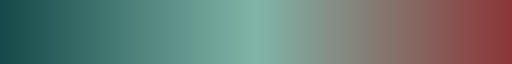

In [388]:
sns.color_palette("blend:#164a4a,#81b5a8,#8c3737", as_cmap=True)

In [398]:
sns.color_palette("blend:#81b5a8,#164a4a,#8c3737")

[(0.5058823529411764, 0.7098039215686275, 0.6588235294117647),
 (0.3380392156862745, 0.5419607843137255, 0.5113725490196078),
 (0.17019607843137252, 0.37411764705882355, 0.363921568627451),
 (0.17882352941176471, 0.27529411764705886, 0.27529411764705886),
 (0.36392156862745095, 0.2454901960784314, 0.2454901960784314),
 (0.5490196078431373, 0.21568627450980393, 0.21568627450980393)]

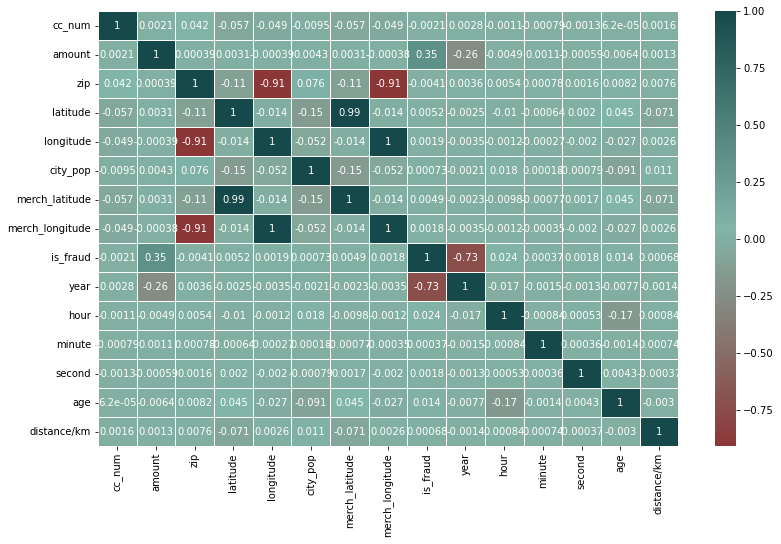

In [397]:
plt.figure(figsize=(13, 8))
matrix = np.triu(p_df.corr())
sns.heatmap(p_df.corr(), annot=True,linewidth=.8, cmap=sns.color_palette("blend:#8c3737,#81b5a8,#164a4a", as_cmap=True));

# **Plot 1**

In [ ]:
df_result = df.groupBy(F.col('is_fraud')).count().orderBy(F.col("count").desc()).toPandas()

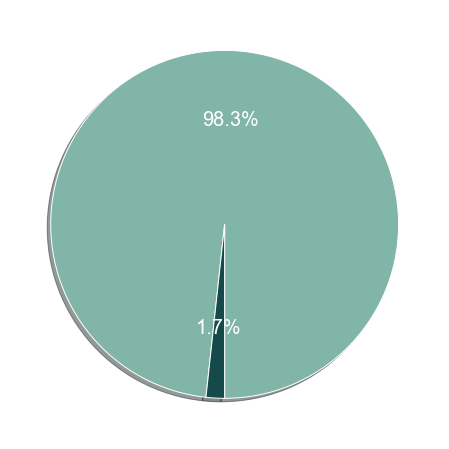

In [ ]:
sns.set(rc={"figure.figsize":(15, 8)})
labels =df_result['is_fraud']
sizes = df_result['count']
plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True, startangle=270, colors=sns.color_palette("blend:#81b5a8,#164a4a",2), textprops={'color':"w",'size':20})
# plt.title('Fraud Ratios',size = 16)
plt.show()

We can see that the number of frauds is  1.7%, whiech mean that only 9651 from 563165

# **Plot 2.1**

In [ ]:
df_result = df.where(F.col('is_fraud')==0).groupBy(F.col('category'),F.col('gender')).count().orderBy(F.col('count').desc()).toPandas()

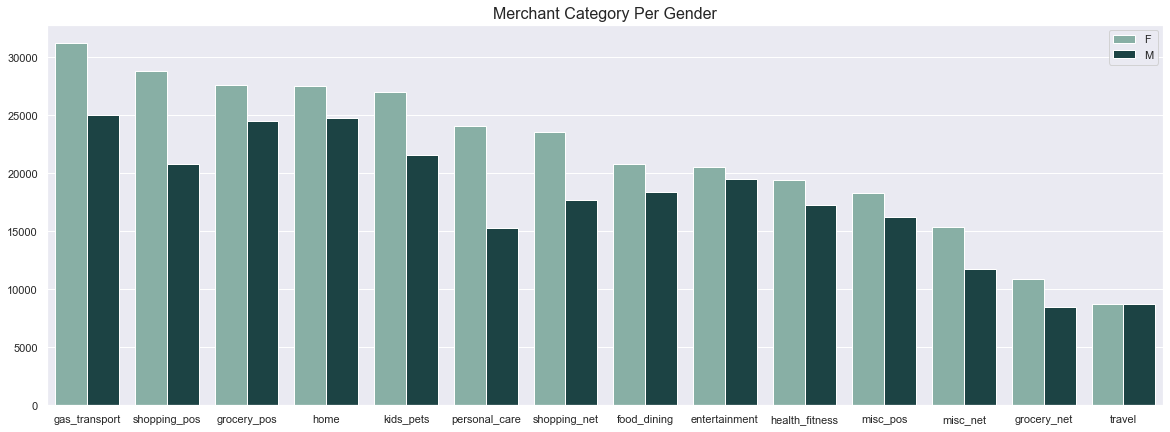

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x="category", y='count', hue = 'gender', data=df_result.unstack(), palette=sns.color_palette("blend:#81b5a8,#164a4a",2))
plt.title('Merchant Category Per Gender',size = 16)
plt.show()

* This plot shows that gas_transport is the highest catagore in the data set , which mean that 10.2% of the  merchant deal happen in gas_transport

* Travel is the lowest category in the dataset and the ratio of male and female are almost the same 

# **Plot 2.2**

In [ ]:
df_result = df.where(F.col('is_fraud')==1).groupBy(F.col('category'),F.col('gender')).count().orderBy(F.col('count').desc()).toPandas()

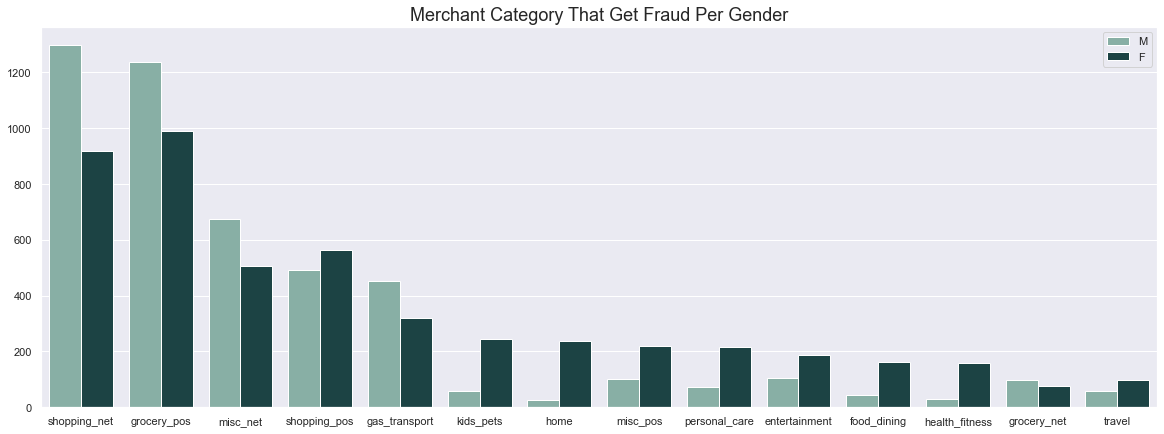

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x="category", y='count', hue = 'gender', data=df_result.unstack() ,palette=sns.color_palette("blend:#81b5a8,#164a4a",2) )
plt.title('Merchant Category That Get Fraud Per Gender',size = 18)
plt.show()

* Shopping_Net is the highest category in which fraud occurs

# **Plot 3**

In [ ]:
df_result = df.groupBy(F.col("gender")).count().toPandas()

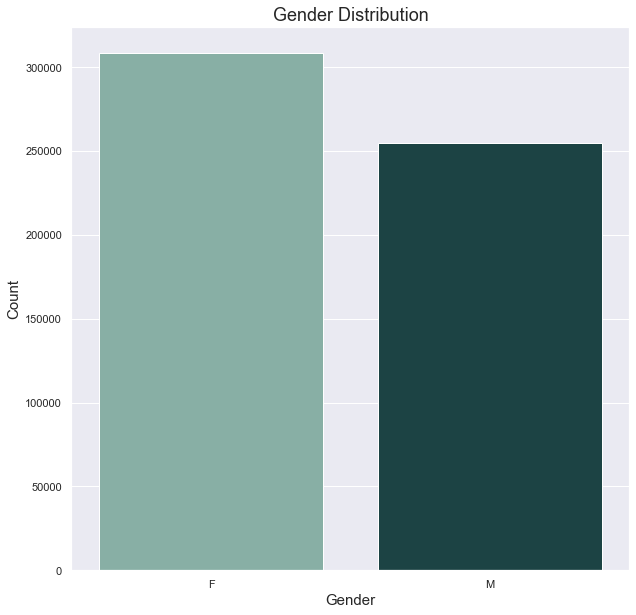

In [ ]:
plt.figure(figsize=(10,10)) 
sns.barplot(x="gender", y="count", data=df_result, palette=sns.color_palette("blend:#81b5a8,#164a4a",2))
plt.title('Gender Distribution',size = 18)
plt.xlabel('Gender', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

This plot shows that the majority of the clients are females

# **Plot 4**

In [ ]:
df_result = df.groupBy(F.col('state')).count().toPandas()

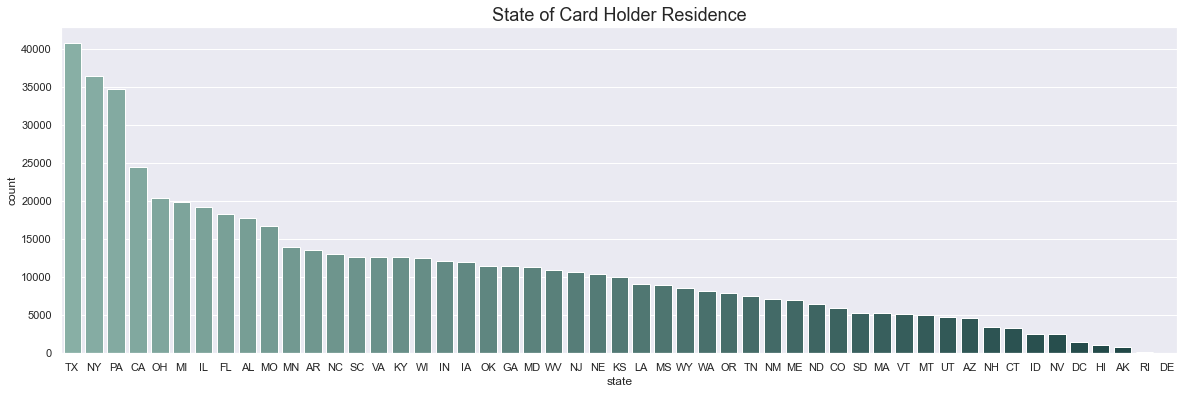

In [ ]:
plt.figure(figsize=(20,6)) 
plt.title('State of Card Holder Residence',size = 18)
sns.barplot(
    x='state', 
    y='count', 
    data=df_result, 
    order=df_result.sort_values('count',ascending=False)['state'],
    palette=sns.color_palette("blend:#81b5a8,#164a4a", len(df_result['state'].unique()))
    ) 
plt.show()

* The highest state in the dtatset is TX (Texas)
* The lowest state in the dtatset is DE (Delaware)
 


# **Plot 5**

In [ ]:
df_result = df.where(F.col('is_fraud')==1).groupBy(F.col('state')).count().toPandas()

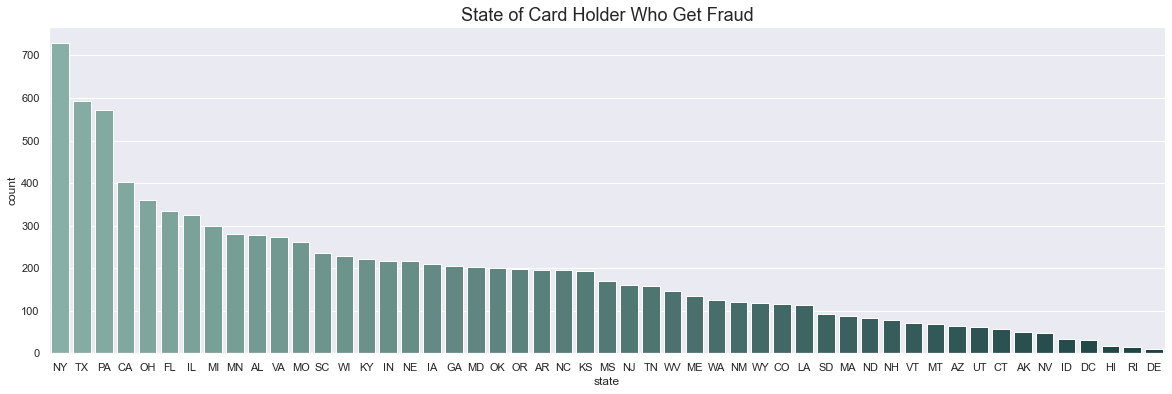

In [ ]:
plt.figure(figsize=(20,6)) 
plt.title('State of Card Holder Who Get Fraud',size = 18)
sns.barplot(
    x='state', 
    y='count', 
    data=df_result, 
    order=df_result.sort_values('count',ascending=False)['state'], 
    palette=sns.color_palette("blend:#81b5a8,#164a4a", len(df_result['state'].unique()))) 
plt.show()

* The highest state that get fraud is NY (New York)
* The lowest state that get fraud is DE (Delaware)

In [ ]:
df.where((F.col('state')=='NY') & (F.col('is_fraud')==0)).select('amount').describe().show()

+-------+------------------+
|summary|            amount|
+-------+------------------+
|  count|             35743|
|   mean| 67.98519905995587|
| stddev|127.92478523952546|
|    min|               1.0|
|    max|           5787.11|
+-------+------------------+



In [ ]:
df.where((F.col('state')=='NY') & (F.col('is_fraud')==1)).select('amount').describe().show()

+-------+-----------------+
|summary|           amount|
+-------+-----------------+
|  count|              730|
|   mean|541.5004383561649|
| stddev|389.3846506853891|
|    min|             1.18|
|    max|          1288.29|
+-------+-----------------+



# **Plot 6**

In [ ]:
df_result = df.groupBy(F.col('card_type')).count().orderBy(F.col('count').desc()).toPandas()

In [ ]:
sns.color_palette("blend:#81b5a8,#164a4a,#ADDBD0,#3F4853",7)

[(0.5058823529411764, 0.7098039215686275, 0.6588235294117647),
 (0.2985467128027681, 0.5024682814302192, 0.47667820069204153),
 (0.0862745098039216, 0.2901960784313726, 0.2901960784313726),
 (0.38583621683967706, 0.5778546712802768, 0.5560322952710496),
 (0.6784313725490196, 0.8588235294117648, 0.8156862745098039),
 (0.46020761245674746, 0.56719723183391, 0.5677047289504037),
 (0.24705882352941178, 0.2823529411764706, 0.3254901960784314)]

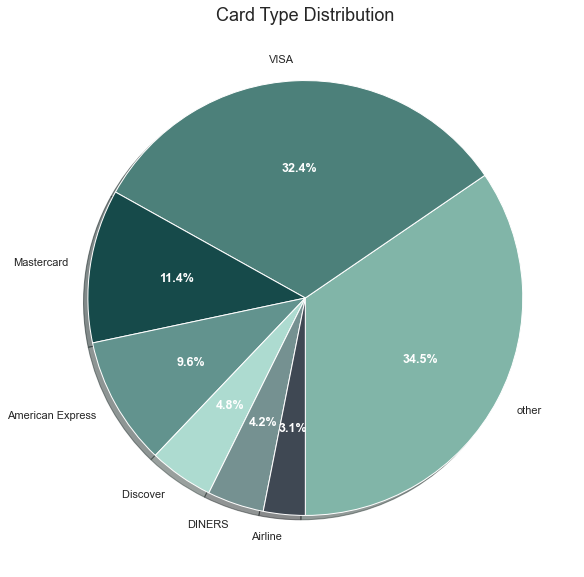

In [ ]:
sns.set(rc={"figure.figsize":(17, 10)})
labels =df_result['card_type']
sizes = df_result['count']
_, _, autopcts = plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True, startangle=270,
colors= sns.color_palette("blend:#81b5a8,#164a4a,#ADDBD0,#3F4853",7)
)

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})

plt.title('Card Type Distribution',size = 18)
plt.show()

* The highest card type used is VISA

# **Plot 7**

In [ ]:
df_result = df.where(F.col('is_fraud')==1).groupBy(F.col('city')).count().orderBy(F.col('count').desc()).toPandas().iloc[:10]

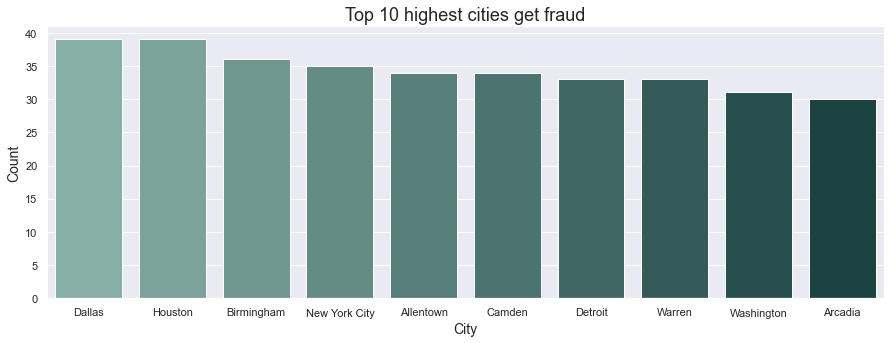

In [ ]:
plt.figure(figsize = (15,5))
plt.title("Top 10 highest cities get fraud",size = 18)
sns.barplot(x="city", y='count',data=df_result,
    palette=sns.color_palette("blend:#81b5a8,#164a4a", len(df_result['city'].unique())) )
plt.xlabel('City', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

The highest cities that get fraud are Houston and Dallas

# **Plot 8**

In [ ]:
df_result_f = df.where(F.col("is_fraud")==1).select('age').toPandas()
df_result_nof = df.where(F.col("is_fraud")==0).select('age').toPandas()

In [ ]:
palette=sns.color_palette("blend:#81b5a8,#164a4a",2)

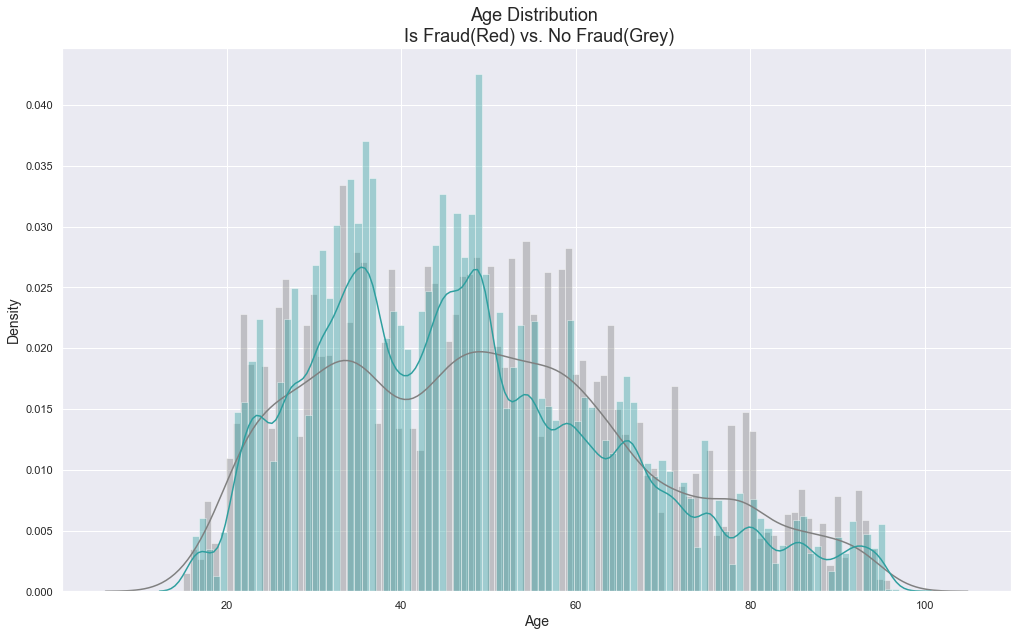

In [ ]:
# Age Distribution

plt.title('Age Distribution \n Is Fraud(Red) vs. No Fraud(Grey)',size = 18)
agedist0 = df_result_f['age']
agedist1 = df_result_nof["age"]
sns.distplot(agedist0, bins = 100, color = "grey")
sns.distplot(agedist1, bins = 100, color = "#2f9f9f")
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()


* The Distribution show that the rang of age is between 15 years old  and 89years old
* Most of the ages that are exposed to fraud are between 50 and more

# **Plot 9**

In [ ]:
df_result = df.groupBy(F.col('day')).count().orderBy(F.col('count').desc()).toPandas()
df_result = df_result.set_index('day').reindex(['Monday','Tuesday',  'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()

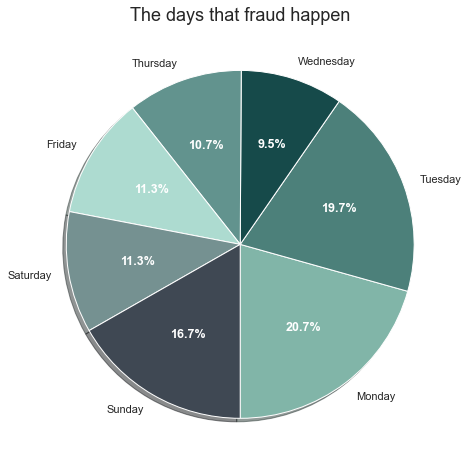

In [ ]:
sns.set(rc={"figure.figsize":(15, 8)})
labels =df_result['day']
sizes = df_result['count']
_, _, autopcts = plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True, startangle=270,
colors= sns.color_palette("blend:#81b5a8,#164a4a,#ADDBD0,#3F4853",7)
)
plt.title('The days that fraud happen',size = 18)
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.show()

Most fraud operation happen in the weekend (saturday & sunday )

# **Plot 10**

In [ ]:
df_result = df.where(F.col('is_fraud')==1).groupBy(F.col('month')).count().orderBy(F.col('count').desc()).toPandas()
df_result = df_result.set_index('month').reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July',
'August', 'September', 'October', 'November', 'December']).reset_index()

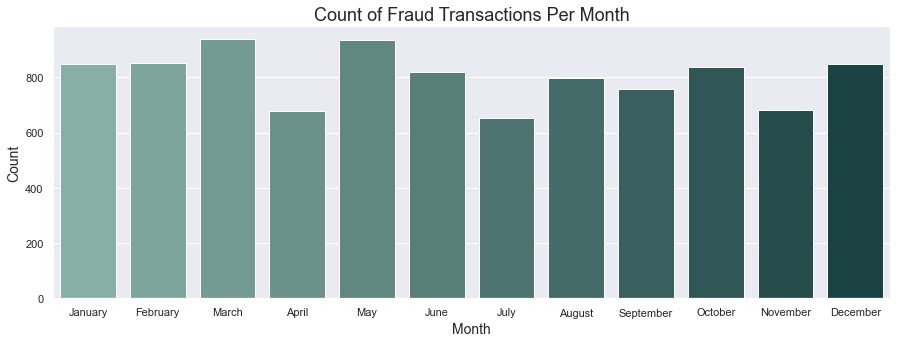

In [ ]:
plt.figure(figsize = (15,5))
plt.title('Count of Fraud Transactions Per Month',size = 18)
sns.barplot(x="month", y="count",data=df_result 
, palette=sns.color_palette("blend:#81b5a8,#164a4a", len(df_result['month'].unique())) )
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

The highest month that fraud operation happen in are Maech and May

# **Plot 11**

In [ ]:
df_result = df.where(F.col('is_fraud')==1).groupBy(F.col('hour')).count().orderBy(F.col('count').desc()).toPandas()

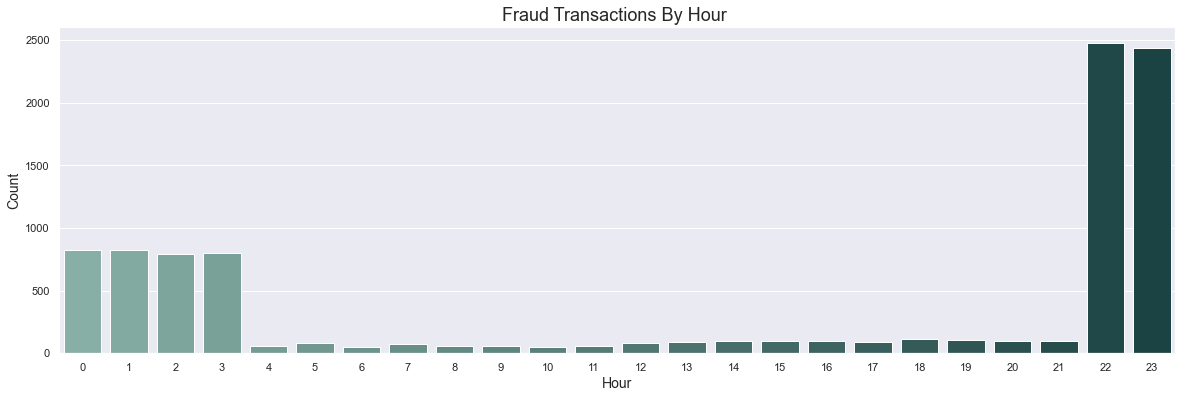

In [ ]:
plt.figure(figsize=(20,6)) 
plt.title('Fraud Transactions By Hour ',size = 18)
sns.barplot(x='hour', y="count", data=df_result
, palette=sns.color_palette("blend:#81b5a8,#164a4a", len(df_result['hour'].unique())) ) 
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

this plot shows that the fraud operation happen between 10PM and 3AM

# **Plot 12**

In [ ]:
df_result = df.where(F.col('is_fraud')==0).groupBy(F.col('job')).count().orderBy(F.col('count').desc()).toPandas().iloc[:5]

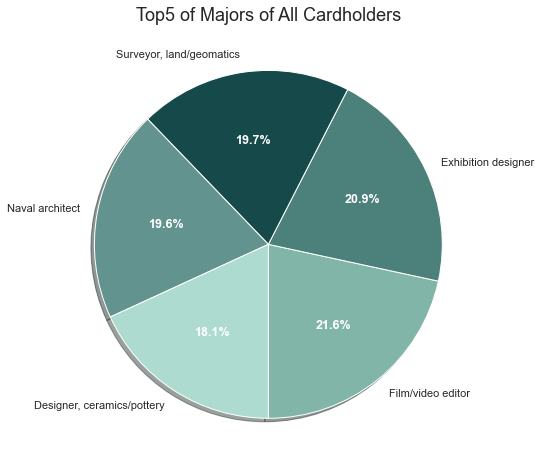

In [ ]:
sns.set(rc={"figure.figsize":(15, 8)})
labels =df_result['job']
sizes = df_result['count']
_, _, autopcts = plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True, startangle=270,
colors= sns.color_palette("blend:#81b5a8,#164a4a,#ADDBD0,#3F4853",7)
)
plt.title('Top5 of Majors of All Cardholders',size = 18)
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.show()

* The highest major of all cardholders who get fraud is Film/video editor


# **Plot 13**

In [ ]:
df_result = df.where(F.col('is_fraud')==1).groupBy(F.col('job')).count().orderBy(F.col('count').desc()).toPandas().iloc[:5]

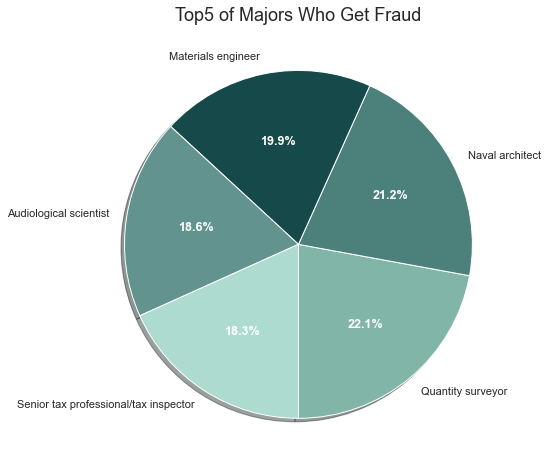

In [ ]:
sns.set(rc={"figure.figsize":(15, 8)})
labels =df_result['job']
sizes = df_result['count']
_, _, autopcts = plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True, startangle=270,
colors= sns.color_palette("blend:#81b5a8,#164a4a,#ADDBD0,#3F4853",7)
)
plt.title('Top5 of Majors Who Get Fraud',size = 18)
plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.show()

* The highest major of all cardholders who get fraud is Materials engineer

***
# Machine Learning Section
***

In [170]:
df.dtypes

[('trans_date_trans_time', 'timestamp'),
 ('cc_num', 'bigint'),
 ('merchant', 'string'),
 ('category', 'string'),
 ('amount', 'double'),
 ('gender', 'string'),
 ('street', 'string'),
 ('city', 'string'),
 ('state', 'string'),
 ('zip', 'int'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('city_pop', 'int'),
 ('job', 'string'),
 ('dob', 'string'),
 ('unix_time', 'int'),
 ('merch_latitude', 'double'),
 ('merch_longitude', 'double'),
 ('is_fraud', 'int'),
 ('year', 'int'),
 ('month', 'string'),
 ('day', 'string'),
 ('hour', 'int'),
 ('age', 'bigint'),
 ('distance/km', 'float')]

In [171]:
# Drop unwanted columns 
df = df.drop('trans_date_trans_time')
df = df.drop('dob')
df = df.drop('day')
df = df.drop('month')

In [172]:
# Get numicral columns
num_cols = [c for c, t in df.dtypes if not t.startswith(('timestamp','string'))]

cat_cols = [c for c, t in df.dtypes if t.startswith(('string'))]

print('Categorical Columns: ', cat_cols)
print('Numirical Columns: ', num_cols)

Categorical Columns:  ['merchant', 'category', 'gender', 'street', 'city', 'state', 'job']
Numirical Columns:  ['cc_num', 'amount', 'zip', 'latitude', 'longitude', 'city_pop', 'unix_time', 'merch_latitude', 'merch_longitude', 'is_fraud', 'year', 'hour', 'age', 'distance/km']


### Imputition

#### Numircal Imputer

In [173]:

#simple imputer that will replace missing values using mean of each column
imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy='mean')
model = imputer.fit(df) #we will first fit the data using the imputer -> here it will calculate the mean for each column
df = model.transform(df) #finally we will transform -> here it will replace the values

##### Categorical Imputer

In [174]:
df = df.fillna('unknown', subset=cat_cols)

### Vectorize the categroical columns

In [175]:
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    df = indexer.fit(df).transform(df) 
    
df = df.drop(*cat_cols) 

In [176]:
df.show()

+----------------+-------+-----+--------+---------+--------+----------+------------------+------------------+--------+----+----+---+-----------+------------+------------+----------+----------+--------+---------+-------+
|          cc_num| amount|  zip|latitude|longitude|city_pop| unix_time|    merch_latitude|   merch_longitude|is_fraud|year|hour|age|distance/km|merchant_idx|category_idx|gender_idx|street_idx|city_idx|state_idx|job_idx|
+----------------+-------+-----+--------+---------+--------+----------+------------------+------------------+--------+----+----+---+-----------+------------+------------+----------+----------+--------+---------+-------+
|   4613314721966| 281.06|28611| 35.9946| -81.7266|     885|1325466397|         36.430124|-81.17948299999999|       1|2019|   1| 31|   68.96272|       128.0|         1.0|       1.0|     306.0|   316.0|     12.0|  210.0|
| 340187018810220|  11.52|78208|   29.44|  -98.459| 1595797|1325468849|         29.819364|        -99.142791|       1|20

### Combine all columns 

In [177]:
cols = df.columns
cols.remove('is_fraud') #remove is_fraud -> we need this to be our label

#vector assembler will take all the columns and convert them into one column called features
assembler = VectorAssembler(inputCols=cols, outputCol='features')

#the .transform will apply the changes here
df = assembler.transform(df)

### Set columns and Split

In [178]:
# We have created a new dataframe only consisting of the features column and the label column (actually is_fraud column but renamed)
df_ml = df.select(F.col('features'), F.col('is_fraud').alias('label'))

#simple data splitting
df_train, df_test = df_ml.randomSplit([0.8, 0.2])

In [179]:
df_ml.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4.613314721966E1...|    1|
|[3.4018701881022E...|    1|
|[3.4018701881022E...|    1|
|[4.613314721966E1...|    1|
|[3.4018701881022E...|    1|
|[4.613314721966E1...|    1|
|[4.613314721966E1...|    1|
|[3.4018701881022E...|    1|
|[3.4018701881022E...|    1|
|[3.4018701881022E...|    1|
|[4.92271083101120...|    1|
|[4.92271083101120...|    1|
|[4.92271083101120...|    1|
|[4.613314721966E1...|    1|
|[4.92271083101120...|    1|
|[4.613314721966E1...|    1|
|[4.613314721966E1...|    1|
|[4.613314721966E1...|    1|
|[3.4018701881022E...|    1|
|[3.41546199006537...|    1|
+--------------------+-----+
only showing top 20 rows



***
# Builidng Model
***

## Logistic Regression

In [249]:
# Define base model and put it in pipline
lr  =LogisticRegression()
pipeline = Pipeline(stages=[lr])

# Add tuning parametes 
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .build()

In [250]:

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

In [251]:
grid_lr = crossval.fit(df_train)

In [252]:
lr_prediction = grid_lr.transform(df_test)

## Random Forest Classifier

In [236]:
# Define base model and put it in pipline
rfc  =RandomForestClassifier()
pipeline = Pipeline(stages=[rfc])

# Add tuning parametes 
paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [10]) \
    .addGrid(rfc.maxBins, [1000]) \
    .build()

In [237]:

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

In [238]:
grid_rfc = crossval.fit(df_train)

In [239]:
rfc_prediction = grid_rfc.transform(df_test)

## Greadient Boost Tree Classifier

In [243]:
# Define base model and put it in pipline
gbtc  =GBTClassifier()
pipeline = Pipeline(stages=[gbtc])

# Add tuning parametes 
paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.maxIter, [5]) \
    .addGrid(gbtc.maxBins, [1000]) \
    .build()

In [244]:

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

In [245]:
grid_gbtc = crossval.fit(df_train)

In [246]:
gbtc_prediction = grid_gbtc.transform(df_test)

# Evaluation

## Baseline 

In [ ]:
baseline = df.groupBy(F.col('is_fraud')).count()

In [ ]:
datasize = df.count()

In [ ]:

@F.udf(returnType=FloatType())
def baseline_prec(count):
    return ((count/datasize)*100)


In [ ]:
baseline.withColumn('normlaized', baseline_prec('count')).show()

+--------+------+----------+
|is_fraud| count|normlaized|
+--------+------+----------+
|       1|  9651| 1.7135248|
|       0|553574| 98.286476|
+--------+------+----------+



**So, the baseline is 98.28 and our best result is 99.73**

### Evaluate on test dataset

In [253]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Accuracy Metric
evaluator_A = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# F1 Metric
evaluator_F = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Weighted Precision
evaluator_P = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

# Weighted Recall
evaluator_R = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Our models
models = [lr_prediction, rfc_prediction, gbtc_prediction]

# Empty lists that will store the scores for each metric for each model.
accuracy = []
F1 = []
precision = []
recall = []

# Simple loop to populate the empty lists with scores of models for each metric.
for model in models:
    accuracy.append(evaluator_A.evaluate(model))
    F1.append(evaluator_F.evaluate(model))
    precision.append(evaluator_P.evaluate(model))
    recall.append(evaluator_R.evaluate(model))

In [254]:
# We will convert all lists created above into a dataframe for easy viewing.
df_ev = pd.DataFrame(list(zip(accuracy, F1, precision, recall)), 
                     columns = ['Accuracy', 'F1 score', 'Weighted Precision', 'Weighted Recall'],
                     index = ['Logistic Regression', 'Random Forest Classifier', 'Greadient Boost Tree Classifier'])
df_ev

,Accuracy,F1 score,Weighted Precision,Weighted Recall
Logistic Regression,0.993458,0.992910,0.993181,0.993458
Random Forest Classifier,0.996217,0.995990,0.996232,0.996217
Greadient Boost Tree Classifier,0.997303,0.997281,0.997268,0.997303


## Evalueate on train set

In [272]:
gbtc_prediction_t = grid_gbtc.transform(df_train)

In [273]:
rfc_prediction_t = grid_rfc.transform(df_train)

In [274]:
lr_prediction_t = grid_lr.transform(df_train)

In [275]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Our models
models = [lr_prediction_t, rfc_prediction_t, gbtc_prediction_t]

# Empty lists that will store the scores for each metric for each model.
accuracy = []
F1 = []
precision = []
recall = []

# Simple loop to populate the empty lists with scores of models for each metric.
for model in models:
    accuracy.append(evaluator_A.evaluate(model))
    F1.append(evaluator_F.evaluate(model))
    precision.append(evaluator_P.evaluate(model))
    recall.append(evaluator_R.evaluate(model))

In [276]:
# We will convert all lists created above into a dataframe for easy viewing.
df_ev_t = pd.DataFrame(list(zip(accuracy, F1, precision, recall)), 
                     columns = ['Accuracy', 'F1 score', 'Weighted Precision', 'Weighted Recall'],
                     index = ['Logistic Regression Train', 'Random Forest Classifier Train', 'Greadient Boost Tree Classifier Train'])
df_ev_t

,Accuracy,F1 score,Weighted Precision,Weighted Recall
Logistic Regression Train,0.993269,0.992637,0.993005,0.993269
Random Forest Classifier Train,0.996547,0.996356,0.996557,0.996547
Greadient Boost Tree Classifier Train,0.998525,0.998501,0.998513,0.998525


## Combine two dataframes

In [357]:
ev_df = pd.concat([df_ev, df_ev_t])

In [359]:
ev_df = ev_df.transpose()
ev_df

,Logistic Regression,Random Forest Classifier,Greadient Boost Tree Classifier,Logistic Regression Train,Random Forest Classifier Train,Greadient Boost Tree Classifier Train
Accuracy,0.993458,0.996217,0.997303,0.993269,0.996547,0.998525
F1 score,0.992910,0.995990,0.997281,0.992637,0.996356,0.998501
Weighted Precision,0.993181,0.996232,0.997268,0.993005,0.996557,0.998513
Weighted Recall,0.993458,0.996217,0.997303,0.993269,0.996547,0.998525


In [362]:
# Get differance between train and test sets
visited = []
for col in ev_df.columns:
    splited_text =col.split(' Train')[0]
    if splited_text in visited:
        break
    ev_df[splited_text+'_diff'] =ev_df.apply(lambda x:  (x[splited_text+' Train'] -x[splited_text])*100, axis=1)
    ev_df.drop([splited_text+' Train'], inplace=True, axis=1)
    visited.append(col)

Logistic Regression
Random Forest Classifier
Greadient Boost Tree Classifier


In [363]:
# The result
ev_df

,Logistic Regression,Random Forest Classifier,Greadient Boost Tree Classifier,Logistic Regression_diff,Random Forest Classifier_diff,Greadient Boost Tree Classifier_diff
Accuracy,0.993458,0.996217,0.997303,-0.018952,0.032941,0.122194
F1 score,0.992910,0.995990,0.997281,-0.027385,0.036661,0.121980
Weighted Precision,0.993181,0.996232,0.997268,-0.017673,0.032525,0.124492
Weighted Recall,0.993458,0.996217,0.997303,-0.018952,0.032941,0.122194


## Get Importance reuslt

In [476]:
features = df.columns
features.remove('features')
features.remove('is_fraud')

df_result = pd.DataFrame(grid_gbtc.bestModel.stages[0].featureImportances.toArray(),index=features,columns=['importance']).reset_index()

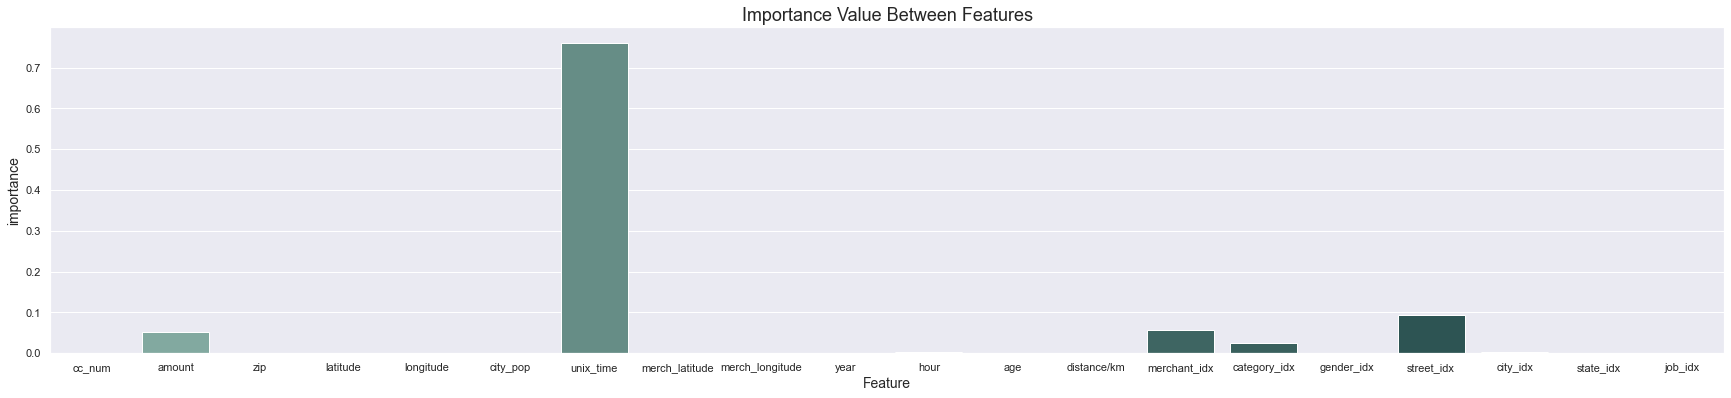

In [481]:
plt.figure(figsize=(30,6)) 
plt.title('Importance Value Between Features',size = 18)
sns.barplot(x='index', y="importance", data=df_result
, palette=sns.color_palette("blend:#81b5a8,#164a4a", len(df_result['index'].unique())) ) 
plt.xlabel('Feature', fontsize=14)
plt.ylabel('importance', fontsize=14)

plt.show()